# Macroprudential Policy and the Housing Market
This notebook solves and simulates the Heterogenous Agent Housing Market (HAH) model and produces the output contained in my Master's thesis. 

**Dependencies:**

The code structure builds upon the framework developed by Jeppe Druedahl & Co. in the [NumEconCopenhagen Project](https://github.com/NumEconCopenhagen)

Packages required for running the notebook are:
- [ConSav](https://pypi.org/project/ConSav/)
- [EconModel](https://pypi.org/project/EconModel/)
- [matplotlib](https://pypi.org/project/matplotlib/)
- [numpy](https://pypi.org/project/numpy/)
- [numba](https://pypi.org/project/numba/)
- [pandas](https://pypi.org/project/pandas/)

### 0.0 Import packages and ModelClass

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import numba as nb
import pandas as pd

nb.set_num_threads(4) # set equal to the number of cores in your CPU

from HAHModel import HAHModelClass

### 0.1 Import data for equivalence scale and life cycle income profile

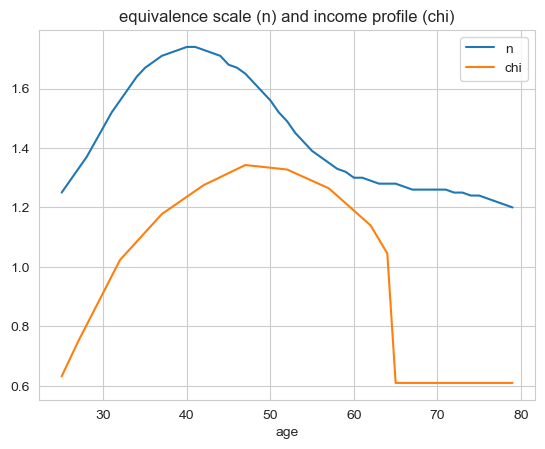

In [2]:
#wd = '/Users/Christian/Dropbox/KU - Polit/KA/Thesis'
data = pd.read_excel(
    io='equiscale.xlsx',
    sheet_name='output')

# adjust income profile and slice
Tr = 65-25 # retirement age - par.Tmin
pension = 0.75 # adjustment for drop in income at retirement

data['chi'] = data['chi'].interpolate(method='linear')+0.1 # quick fix to get mean ca. one
data = data.iloc[3:-3,:]
data['chi'].iloc[Tr:] = pension*np.mean(data['chi'].iloc[Tr:])

## extract arrays
n = data['n'].to_numpy(dtype='float')
chi = data['chi'].to_numpy(dtype='float') 
#chi[Tr:] = pension*np.mean(chi[Tr:])

# plot data
data.plot(x='t_plus_Tmin',y=['n','chi'])
plt.xlabel('age')
plt.title('equivalence scale (n) and income profile (chi)');

## 1 Baseline model

In [21]:
# initialise an instance of baseline model
model_baseline = HAHModelClass(
    name='baseline',
    par={
        'zeta':10, # increased utility cost of default
        'kappa':0.0,
        'thetab':250,
        'K':10, 
        'omega_ltv':0.9,  
        'C_buy':0.0,   # JEJA sets the buyer cost to zero 
        'chi':chi,
        'n':n,
        'do_print':True,
        'include_unemp':False
        })

model_baseline.precompile_numba() # solve model with very coarse grids --> speed gains
model_baseline.solve()
model_baseline.simulate()
#model_baseline.save()

 t = 3 solved in 55.5 secs
 t = 2 solved in 44.9 secs
 t = 1 solved in 0.0 secs
 t = 0 solved in 0.0 secs
 total precomputation time  = 61.8 secs
 total stay-time  = 8.8 secs
 total ref-time   = 10.9 secs
 total buy-time   = 9.6 secs
 total rent-time   = 9.3 secs
 full model solved in = 100.4 secs
model simulated in 52.6 secs
numba precompiled in 159.5 secs
 last period bequest computed in 0.0 secs
 solved stayer problem in 0.1 secs
 solved refinance problem in 0.0 secs
 solved buyer problem in 0.0 secs
 solved renter problem in 0.0 secs
 t = 54 solved in 0.2 secs
 v_bar and q computed in 1.6 secs
 solved stayer problem in 0.2 secs
 solved refinance problem in 0.0 secs
 solved buyer problem in 0.0 secs
 solved renter problem in 0.0 secs
 t = 53 solved in 1.8 secs
 v_bar and q computed in 1.9 secs
 solved stayer problem in 0.2 secs
 solved refinance problem in 0.0 secs
 solved buyer problem in 0.0 secs
 solved renter problem in 0.0 secs
 t = 52 solved in 2.1 secs
 v_bar and q computed i

### 1.0 Decision Functions

In [22]:
import figs
#figs.decision_functions(model_baseline)

### 1.1 Life Cycle Behaviour

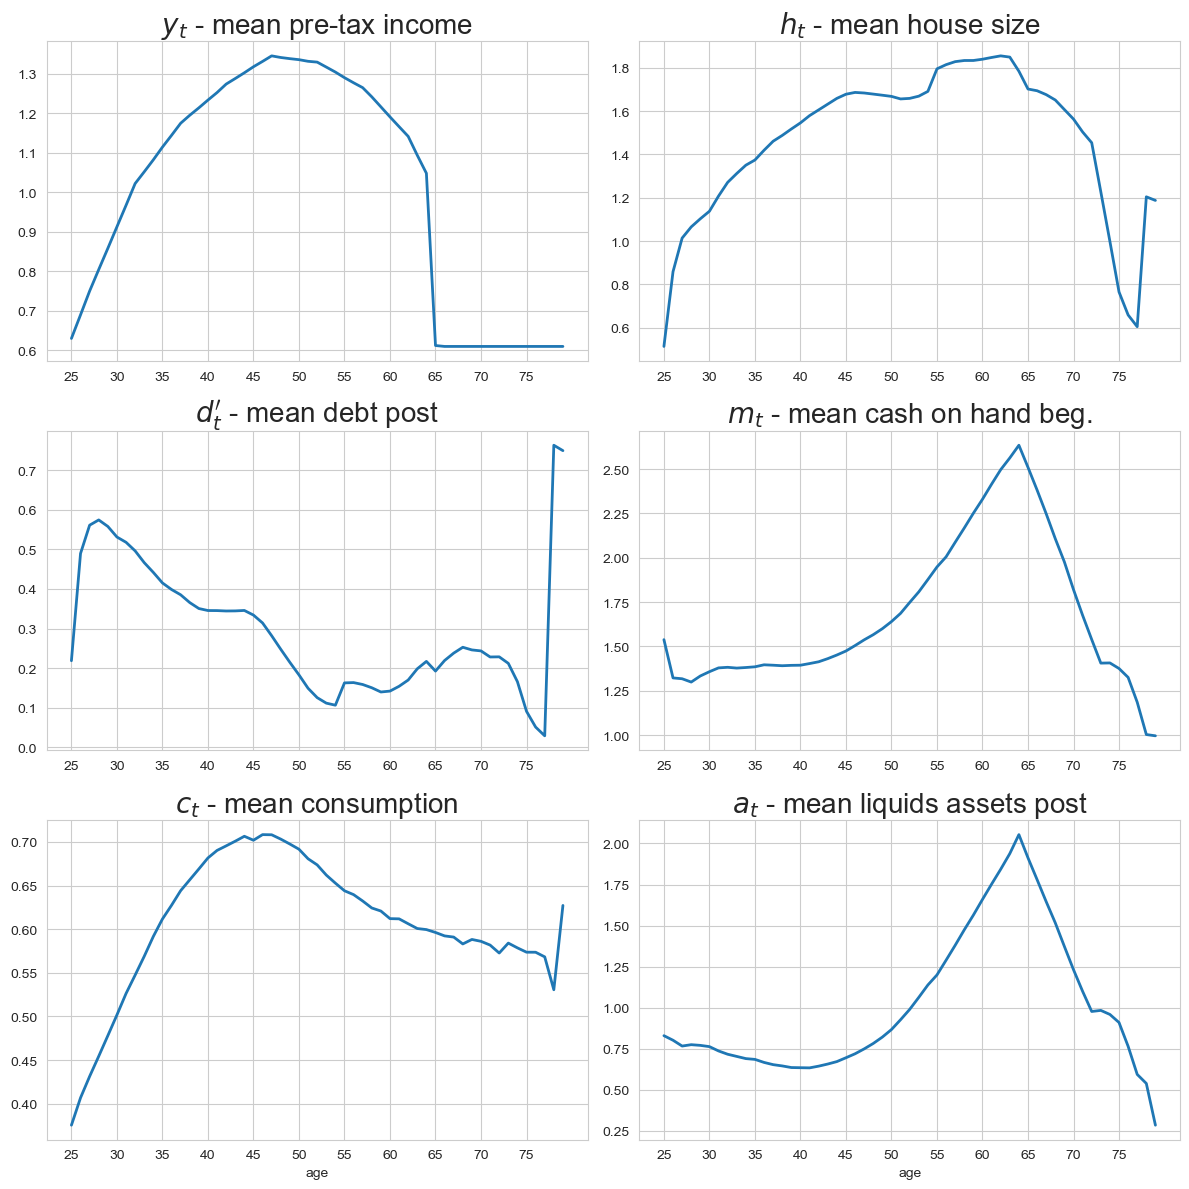

In [23]:
import figs

# average behaviour over the life cycle
figs.lifecycle(model_baseline)

### 1.3 Validate simulation

In [24]:
# unpack
sim = model_baseline.sim 
par = model_baseline.par

# validate consumption decision
I = sim.c < 0 # negative consumption?


print(f'there are {np.sum(I)} cases of negative consumption.') 
if np.sum(I) > 0:
    print(f'ref accounts for {np.sum(I*(sim.discrete==1))} and buy for {np.sum(I*(sim.discrete==2))}.')
    print(f'stay accounts for {np.sum(I*(sim.discrete==0))} and rent for {np.sum(I*(sim.discrete==3))}')
    print(f'the share of negative consumption cases is {np.sum(I)/(par.simN*par.T)}')
    print()
    print('negative simulated consumption occurs in periods:')
    print(np.unique(np.where(sim.c < 0)[0],return_counts=True)[0])
    print('and cases per period are:')
    print(np.unique(np.where(sim.c < 0)[0],return_counts=True)[1])

there are 4276 cases of negative consumption.
ref accounts for 1788 and buy for 2488.
stay accounts for 0 and rent for 0
the share of negative consumption cases is 0.0007774545454545455

negative simulated consumption occurs in periods:
[52 53]
and cases per period are:
[  25 4251]


taxes to labour income is 0.3539
median pre tax income is 0.6097
mean pre tax income is 1.0058


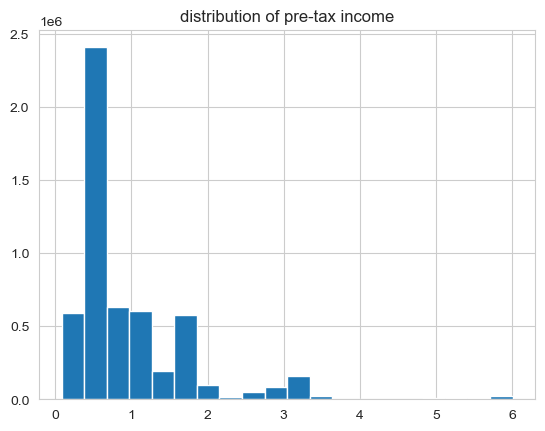

In [25]:
#print(np.unique(sim.Td_prime[52],return_counts=True))
#print(f'{(np.unique(sim.d[40],return_counts=True)[0])}')
#print(f'{np.unique(sim.d[40],return_counts=True)[1]}')
y = sim.y
inc_tax = sim.inc_tax
tax_to_inc = np.sum(inc_tax)/np.sum(y)
print(f'taxes to labour income is {tax_to_inc:.4f}')
print(f'median pre tax income is {np.median(y):.4f}')
print(f'mean pre tax income is {np.mean(y):.4f}')

plt.hist(y.flatten(),bins=20)
plt.title('distribution of pre-tax income');


In [26]:
# validate housing and rental decisions
print('the distribution of house choices is:')
print(np.unique(sim.h,return_counts=True)[0])
print(np.unique(sim.h,return_counts=True)[1])
print()
print('the distribution of rental choices is:')
print(np.unique(sim.h_tilde,return_counts=True)[0])
print(np.unique(sim.h_tilde,return_counts=True)[1])
print()
print(f'mean homeowner share is {np.unique(sim.h_tilde,return_counts=True)[1][0]/(par.T*par.simN):.4f}')

the distribution of house choices is:
[0.   1.42 1.89 2.51 3.34 4.44 5.91]
[1993080 1796803  437629  491652  241918  449601   89317]

the distribution of rental choices is:
[0.   1.07 1.42 1.89]
[3914377 1225050  203985  156588]

mean homeowner share is 0.7117


In [27]:
# validate mortage decision
D = sim.d > 0 # take mortgage?
Dp = sim.d_prime > 0
DA = sim.Tda > 0 # choose deferred amortisation?
t_mat = np.outer(np.arange(par.T),np.ones(par.simN))
D_org = Dp*(sim.Td_prime - par.Td_bar == t_mat) # boolean for loan originations

print(f'average mortgage size at origination is {np.mean(sim.d_prime[D_org]):.4f}')
print(f'sum of outstanding mortgage balances are {np.sum(sim.d):.4f}')
print(f'periods where mortgages are issued are {np.where(np.sum(sim.d,axis=1)>0)[0]}')

average mortgage size at origination is 1.1542
sum of outstanding mortgage balances are 1484486.3977
periods where mortgages are issued are [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54]


In [96]:
# validate impact of financial regulation
ltv_denom = sim.h[D_org]
ltv_num = sim.d[D_org]
dti_denom = sim.y[D_org]
ltvs = ltv_num/ltv_denom
dtis = ltv_num/dti_denom

print('the distribution of DA periods is:')
print(np.unique(sim.Tda,return_counts=True)[0])
print(np.unique(sim.Tda,return_counts=True)[1])
print(f'and the share of DA mortgages is {np.sum(DA)/np.sum(D):.4f}') # is this share correct???
print()
print(f'mean LTV is {np.mean(ltvs):.4f} and mean DTI is {np.mean(dtis):.4f} at mortgage origination')

/var/folders/23/m5wgdyb92cs9fl4fls0nt3xw0000gn/T/ipykernel_1274/1937155328.py:5: RuntimeWarning: invalid value encountered in true_divide
  ltvs = ltv_num/ltv_denom


the distribution of DA periods is:
[0. 1. 2. 3. 4. 5. 6. 7. 8.]
[5293408   31171   33836   38609   40721   10799   15583   17707   18166]
and the share of DA mortgages is 0.1575

mean LTV is nan and mean DTI is 0.1775 at mortgage origination


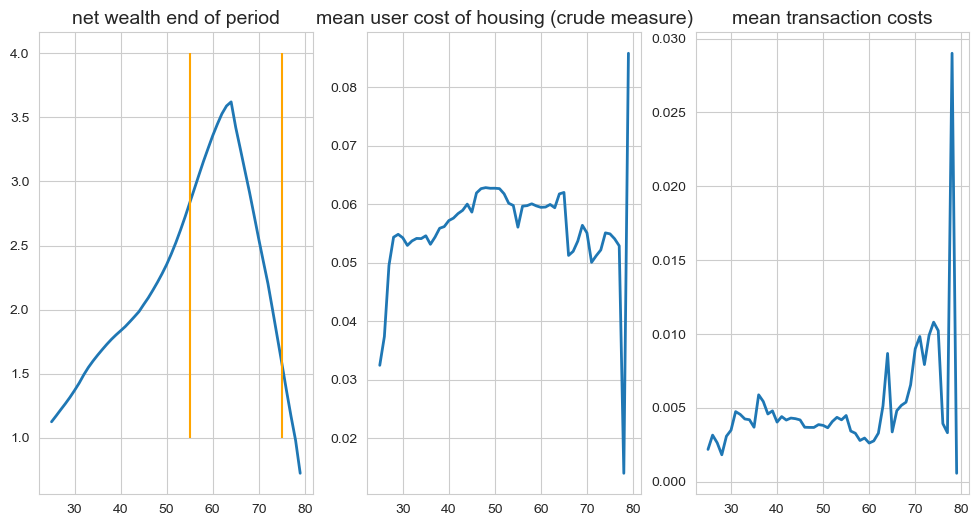

In [28]:
figs.nw_and_tc(model_baseline)

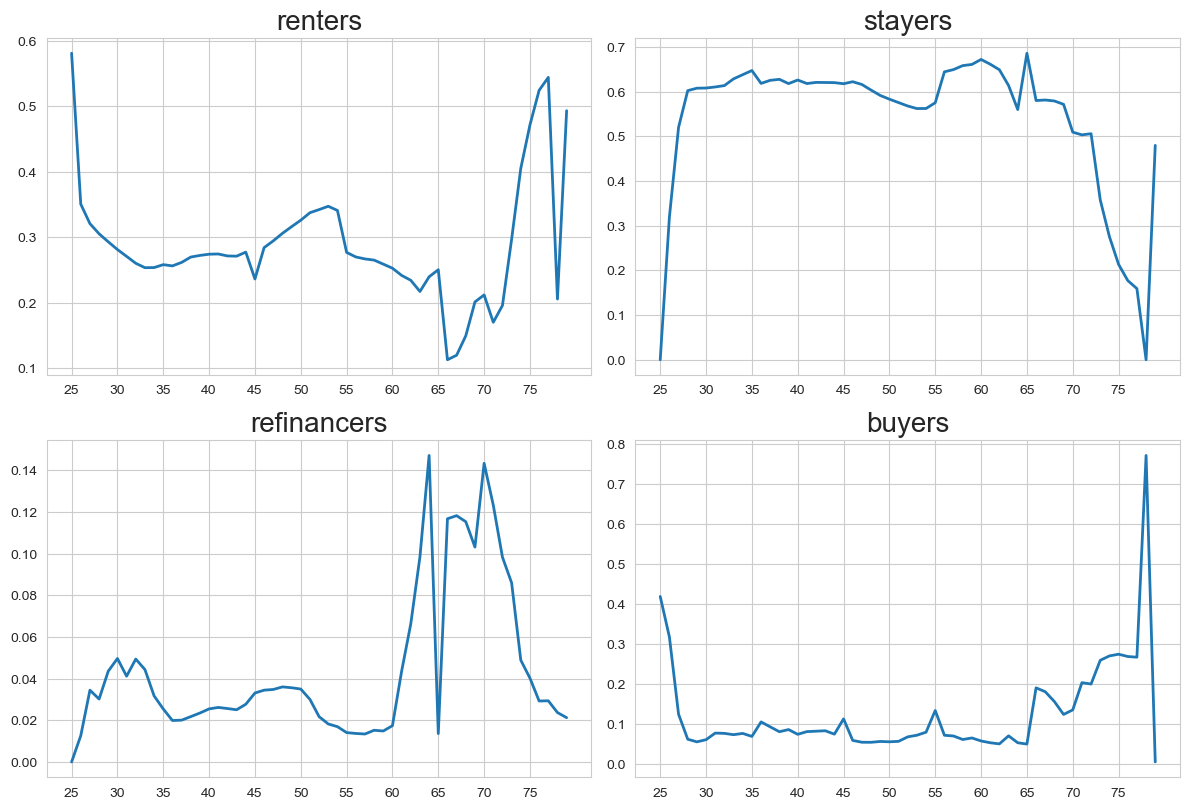

In [29]:
figs.homeownership(model_baseline)

### Loop to match bequest level with initial wealth

In [30]:
# a. unpack
par = model_baseline.par
sim = model_baseline.sim 

# find mean bequest for initial guess
import trans
from EconModel import jit
with jit(model_baseline) as model:
    par = model.par
    ab_tot = 0
    t = par.T-1
    for n in range(par.simN):
        ab_tot += trans.ab_plus_func(
            sim.a[t,n],
            sim.d_prime[t,n],
            sim.Tda_prime[t,n],
            sim.h_prime[t,n],
            par)
    ab_mean = ab_tot/par.simN
print(f'initial wealth is {np.sum(sim.a0):.4f}')
print(f'total bequest is {ab_tot:.4f}')
print(f'mean bequest is {ab_mean:.4f}')
print(f'average hh pre-tax income is {np.mean(sim.y)*670_000:.4f}')

initial wealth is 90849.0092
total bequest is 68016.8821
mean bequest is 0.6802
average hh pre-tax income is 673892.5160


In [193]:
# agggregate housing demand
H_d = np.sum(sim.h) + np.sum(sim.h_tilde)
print(f'aggregate housing demand for purchase and rental is {H_d:.4f}')

aggregate housing demand for purchase and rental is 11261904.5300


In [194]:
import steady_state
steady_state.bequest_loop(model_baseline,ab_mean)

iteration = 1, discrepancy = 0.537641
iteration = 2, discrepancy = 0.249686
iteration = 3, discrepancy = 0.115958
iteration = 4, discrepancy = 0.053740
iteration = 5, discrepancy = 0.025475
iteration = 6, discrepancy = 0.011682
iteration = 7, discrepancy = 0.005148
iteration = 8, discrepancy = 0.002540
iteration = 9, discrepancy = 0.001247
iteration = 10, discrepancy = 0.000597
iteration = 11, discrepancy = 0.000275
iteration = 12, discrepancy = 0.000109
iteration = 13, discrepancy = 0.000019
iteration = 14, discrepancy = 0.000014
iteration = 15, discrepancy = 0.000010
iteration = 16, discrepancy = 0.000005
iteration = 17, discrepancy = 0.000004
iteration = 18, discrepancy = 0.000002
iteration = 19, discrepancy = 0.000001
convergence achieved in 19 simulations, mean bequest = 1.267375


### Test solving the household problem for a few periods

In [ ]:
import HHproblems as hhp
from EconModel import jit

par = model_baseline.par

t = 22
Td_len = np.fmin(t+2,par.Td_shape)
Tda_len = np.fmin(par.Tda_bar,par.T-t+1)

with jit(model_baseline) as model: 
    sol = model.sol
    par = model.par
    #hhp.postdecision_compute_v_bar_q_rent.py_func(t,sol,par)
    #hhp.postdecision_compute_v_bar_q_own.py_func(t,sol,par)
    #assert np.all((sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:] > 0) & 
    #   (np.isnan(sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    #assert np.all((sol.q[t,:,:,0:Td_len,0:Tda_len,:,:] > 0) & 
    #   (np.isnan(sol.q[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t                  
    #print('post decision is done')
    #hhp.solve_stay(t,sol,par)
    #assert np.all((sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:] >= 0) & 
    #   (np.isnan(sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    #assert np.all((sol.inv_v_stay[t,:,:,0:Td_len,0:Tda_len,:,:] >= 0) & 
    #   (np.isnan(sol.inv_v_stay[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    #print('stay is done')
    #hhp.solve_ref_fast(t,sol,par)
    #assert np.all((sol.c_ref_fast[t] >= 0) & (np.isnan(sol.c_ref_fast[t]) == False)), t
    #assert np.all((sol.d_prime_ref_fast[t] >= 0) & (np.isnan(sol.d_prime_ref_fast[t]) == False)), t
    #assert np.all((sol.inv_v_ref_fast[t] >= 0) & (np.isnan(sol.inv_v_ref_fast[t]) == False)), t
    #print('refinance is done')
    #hhp.solve_buy_fast(t,sol,par)
    #assert np.all((sol.c_buy_fast[t] >= 0) & (np.isnan(sol.c_buy_fast[t]) == False)), t
    #assert np.all((sol.d_prime_buy_fast[t] >= 0) & (np.isnan(sol.d_prime_buy_fast[t]) == False)), t
    #assert np.all((sol.inv_v_buy_fast[t] >= 0) & (np.isnan(sol.inv_v_buy_fast[t]) == False)), t                
    #print('buy is done')
    #hhp.solve_rent(t,sol,par)
    #assert np.all((sol.c_rent[t] >= 0) & (np.isnan(sol.c_rent[t]) == False))
    #assert np.all((sol.inv_v_rent[t] >= 0) & (np.isnan(sol.inv_v_rent[t]) == False))            
    #print('rent is done')
    t = t-1
    print(f'start solving t={t}')
    #hhp.postdecision_compute_v_bar_q.py_func(t,sol,par)
    hhp.postdecision_compute_v_bar_q_rent.py_func(t,sol,par)
    hhp.postdecision_compute_v_bar_q_own.py_func(t,sol,par)
    assert np.all((sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:] > 0) & 
       (np.isnan(sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    assert np.all((sol.q[t,:,:,0:Td_len,0:Tda_len,:,:] > 0) & 
       (np.isnan(sol.q[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t                  
    print('post decision is done')
    hhp.solve_stay(t,sol,par)
    assert np.all((sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:] >= 0) & 
       (np.isnan(sol.c_stay[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    assert np.all((sol.inv_v_stay[t,:,:,0:Td_len,0:Tda_len,:,:] >= 0) & 
       (np.isnan(sol.inv_v_stay[t,:,:,0:Td_len,0:Tda_len,:,:]) == False)), t
    print('stay is done')
    hhp.solve_ref_fast(t,sol,par)
    assert np.all((sol.c_ref_fast[t] >= 0) & (np.isnan(sol.c_ref_fast[t]) == False)), t
    assert np.all((sol.d_prime_ref_fast[t] >= 0) & (np.isnan(sol.d_prime_ref_fast[t]) == False)), t
    assert np.all((sol.inv_v_ref_fast[t] >= 0) & (np.isnan(sol.inv_v_ref_fast[t]) == False)), t
    print('refinance fast is done')
    hhp.solve_buy_fast(t,sol,par)
    assert np.all((sol.c_buy_fast[t] >= 0) & (np.isnan(sol.c_buy_fast[t]) == False)), t
    assert np.all((sol.d_prime_buy_fast[t] >= 0) & (np.isnan(sol.d_prime_buy_fast[t]) == False)), t
    assert np.all((sol.inv_v_buy_fast[t] >= 0) & (np.isnan(sol.inv_v_buy_fast[t]) == False)), t                
    print('buy fast is done')
    hhp.solve_rent(t,sol,par)
    assert np.all((sol.c_rent[t] >= 0) & (np.isnan(sol.c_rent[t]) == False))
    assert np.all((sol.inv_v_rent[t] >= 0) & (np.isnan(sol.inv_v_rent[t]) == False))            
    print('rent is done')

### Sanity checks

In [71]:
# check NaNs in relevant part of sol.inv_v_bar

#nan_mat_v = np.argwhere(np.isnan(sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:]))
#print(f'size of q at t={t} is {sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:].size}')
#print(f'there are {nan_mat_v.shape[0]} NaN entries')
#print(f'the nan indices are {nan_mat_v}')
#
## check zero or negative entries in relevant part of sol.inv_v_bar
#zero_mat_v= np.argwhere(sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:] <= 0)
#print(f'size of c_endo at t={t} with Tda in 0,1,2 is {sol.inv_v_bar[t,:,:,0:Td_len,0:Tda_len,:,:].size}')
#print(f'there are {zero_mat_v.shape[0]} zero or negative entries')
#print(f'the zero indices/negative are {zero_mat_v}')

par = model_baseline.par
sol = model_baseline.sol

t = 21
Td_len = np.fmin(t+2,par.Td_shape)
Tda_len = np.fmin(par.Tda_bar,par.T-t+1)

#nan_mat_q = np.argwhere(np.isnan(sol.q[t,6,0:3,0:Td_len,0:Tda_len,4:,:]))
#print(f'size of q at t={t} is {sol.q[t,6,0:3,0:Td_len,0:Tda_len,:,:].size}')
#print(f'there are {nan_mat_q.shape[0]} NaN entries')
#print(f'the nan indices are {nan_mat_q}')

# check zero or negative entries in relevant part of sol.inv_v_bar
zero_mat_q= np.argwhere(sol.q[t,:,:,0:Td_len,0:Tda_len,:,:] <= 0)
print(f'size of q at t={t} is {sol.q[t,6,0:3,0:Td_len,0:Tda_len,4:,9].size}')
print(f'there are {zero_mat_q.shape[0]} zero or negative entries')
print(f'the zero indices/negative are {zero_mat_q}')


size of q at t=21 is 2277
there are 253 zero or negative entries
the zero indices/negative are [[ 6  0  0  0  5  9]
 [ 6  0  0  1  5  9]
 [ 6  0  0  2  5  9]
 ...
 [ 6  0 22  8  5  9]
 [ 6  0 22  9  5  9]
 [ 6  0 22 10  5  9]]


In [ ]:
from EconModel import jit
import utility

# a. unpack
with jit(model_baseline) as model:
    par = model_baseline.par
    sim = model_baseline.sim 

# b. check utility function
c = 1
h = 1
move = 0 
rent = 1
t = 20
n = par.n[t]
nu = 0.4
alpha = 1.1
s = (1-rent)*h/n + par.phi*rent*h/n
print(f' rent utility is {utility.func(c,h,move,rent,t,par)}')
print(f' own utility is {utility.func(c,h,move,0,t,par)}')
print(f' diff is {utility.func(c,h,move,rent,t,par)-utility.func(c,h,move,0,t,par)}')
print(f' s ={s}')
print(f' u(s) ={nu/(1-alpha)*s**(1-alpha)}')
print(f' u(h) ={nu/(1-alpha)*(h/n)**(1-alpha)}')
print(f' diff is {nu/(1-alpha)*s**(1-alpha)-nu/(1-alpha)*(h/n)**(1-alpha)}')

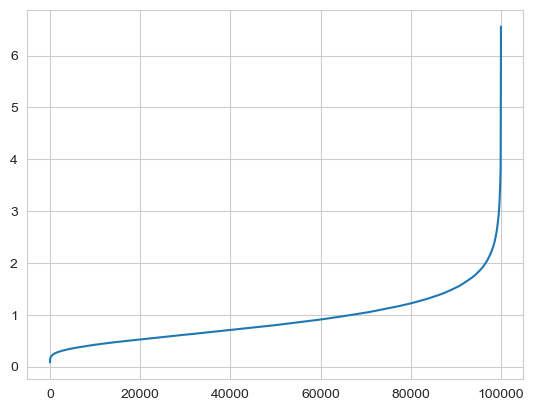

In [31]:
plt.plot(np.sort(sim.a0));